In [1]:
rm -rf /kaggle/working/detectron2

In [24]:
rm -rf /kaggle/working/output/model_0014999.pth

In [2]:
!python -m pip -q install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip -q install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install git+https://github.com/facebookresearch/detectron2.git

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-jyea1k7r/pyyaml_367560e918c94da9b2a5cd9626ed8792/setup.py", line 291, in <module>
          setup(
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 184, in setup
          return run_commands(dist)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 200, in run_commands
          dist.run_commands()
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/dist.py", line 969, in run_commands
          self.run_command(cmd)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/dist.py", line 968, in run_command
          super().run_command(command)
        File "/op

In [3]:
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

detectron2 version: 0.6


In [4]:
import numpy as np
import os, json, cv2, random
from IPython import display
import PIL
import matplotlib.pyplot as plt

# importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


SEED = 9
THRESHOLD = 0.3

In [5]:
import json
import copy
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random

# Function to update category ids in annotations to 0 (binary fractured label)
def update_annotations(annotations, image_id_offset, annotation_id_offset):
    updated_annotations = copy.deepcopy(annotations)
    for annotation in updated_annotations:
        annotation["category_id"] = 1  # Set category to binary class "fractured"
        annotation["id"] += annotation_id_offset
        annotation["image_id"] += image_id_offset
    return updated_annotations

# Function to update the image paths for each dataset
def update_image_paths(images, base_path, image_id_offset):
    updated_images = copy.deepcopy(images)
    for image in updated_images:
        image["file_name"] = f"{base_path}/{image['file_name']}"  # Update file path
        image["id"] += image_id_offset  # Update image ID to avoid conflicts
    return updated_images

def add_dummy_annotations(coco_data):
    image_ids_with_annotations = {ann['image_id'] for ann in coco_data['annotations']}
    all_image_ids = {img['id'] for img in coco_data['images']}
    image_ids_without_annotations = all_image_ids - image_ids_with_annotations
#     print(len(image_ids_without_annotations))
    
    # Create dummy annotations for those images (background, i.e., no object)
    dummy_category_id = 0  # assuming "0" means background or no class
    annotation_id_offset = len(coco_data['annotations'])
    image_ids_without_annotations = random.sample(image_ids_without_annotations, len(image_ids_with_annotations))
    print(len(image_ids_without_annotations))
    for i, image_id in enumerate(image_ids_without_annotations):
        dummy_annotation = {
            'id': annotation_id_offset + i,
            'image_id': image_id,
            'category_id': dummy_category_id,
            'bbox': [0, 0, 0, 0],  # no object, so an empty bbox
            'area': 0,
            'iscrowd': 0
        }
        coco_data['annotations'].append(dummy_annotation)
    return coco_data
    

Run for Kaggle dataset

In [6]:
# Load the two COCO annotation files
with open('/kaggle/input/bone-fracture-detection-detection-coco-annots/train_annotations.coco.json', 'r') as f:
    coco_big = json.load(f)

with open('/kaggle/input/fracatlas-original-dataset/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json', 'r') as f:
    coco_fracAtlas = json.load(f)

# Paths where images are located for each dataset
big_image_path = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images'
fracAtlas_image_path = '/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Fractured'

# Create a new dictionary to hold the merged dataset
combined_coco = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 0, "name": "fractured"}],  # Only binary class label
}


# Merge images and annotations from the first dataset (coco_big)
image_id_offset = 0
annotation_id_offset = 0
combined_coco["images"].extend(update_image_paths(coco_big["images"], big_image_path, image_id_offset))
combined_coco["annotations"].extend(update_annotations(coco_big["annotations"], image_id_offset, annotation_id_offset))

# Update offsets to avoid conflicts in image and annotation IDs
image_id_offset = len(coco_big["images"])
annotation_id_offset = len(coco_big["annotations"])

# Merge images and annotations from the second dataset (coco_fracAtlas)
combined_coco["images"].extend(update_image_paths(coco_fracAtlas["images"], fracAtlas_image_path, image_id_offset))
combined_coco["annotations"].extend(update_annotations(coco_fracAtlas["annotations"], image_id_offset, annotation_id_offset))

# non_fracAtlas_image_path = '/kaggle/input/fracatlas-original-dataset/FracAtlas/images/Non_fractured'
# image_id_offset = len(combined_coco["images"])
# non_fractured_images = []
# for i, image_path in enumerate(Path(non_fracAtlas_image_path).glob("*.jpg")):
#     image = cv2.imread(image_path)
#     image_info = {
#         "id": image_id_offset + i,
#         "file_name": f"{non_fracAtlas_image_path}/{image_path.name}",
#         "width": image.shape[1],
#         "height": image.shape[0],
#     }
#     non_fractured_images.append(image_info)

# combined_coco["images"].extend(non_fractured_images)

# add_dummy_annotations(combined_coco)

# Save the combined dataset as a new JSON file
with open('combined_annotations.coco.json', 'w') as f:
    json.dump(combined_coco, f)

print("Combined COCO dataset with updated image paths created successfully!")

Combined COCO dataset with updated image paths created successfully!


Run for Custom data

In [6]:
import json
import copy
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Load the two COCO annotation files
with open('/kaggle/input/augmented-fracture-data/train/_annotations.coco.json', 'r') as f:
    coco_big = json.load(f)

# Paths where images are located for each dataset
# big_image_path = '/kaggle/input/augmented-fracture-data/train'

# # Create a new dictionary to hold the merged dataset
# combined_coco = {
#     "images": [],
#     "annotations": [],
#     "categories": [{"id": 0, "name": "fractured"}],  # Only binary class label
# }

# # Merge images and annotations from the first dataset (coco_big)
# image_id_offset = 0
# annotation_id_offset = 0
# combined_coco["images"].extend(update_image_paths(coco_big["images"], big_image_path, image_id_offset))
# combined_coco["annotations"].extend(update_annotations(coco_big["annotations"], image_id_offset, annotation_id_offset))

# # Update offsets to avoid conflicts in image and annotation IDs
# image_id_offset = len(coco_big["images"])
# annotation_id_offset = len(coco_big["annotations"])

# add_dummy_annotations(coco_big)
coco_big['categories'] = [
        {
            "id": 0,
            "name": "No Fracture",
            "supercategory": "none"
        },
        {
            "id": 1,
            "name": "Fracture",
            "supercategory": "none"
        }
    ]
# Save the combined dataset as a new JSON file
with open('combined_annotations.coco.json', 'w') as f:
    json.dump(coco_big, f)

print("Combined COCO dataset with updated image paths created successfully!")

Combined COCO dataset with updated image paths created successfully!


In [7]:
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

register_coco_instances(f"bone_fractures_big", {},
                            '/kaggle/working/combined_annotations.coco.json',
                            '/kaggle/input/augmented-fracture-data/train')

register_coco_instances(f"bone_fractures_test", {},
                            '/kaggle/input/augmented-fracture-data/valid/_annotations.coco.json',
                            '/kaggle/input/augmented-fracture-data/valid')

In [8]:
import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("bone_fractures_big")
train_dataset_dicts = DatasetCatalog.get("bone_fractures_big")

# A function that creates examples from the dataset
def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
#     np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]
    
    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        print(img_link)
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()
        
        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

WARNING [11/26 15:31:41 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/26 15:31:41 d2.data.datasets.coco]: Loaded 20633 images in COCO format from /kaggle/working/combined_annotations.coco.json


/kaggle/input/augmented-fracture-data/train/image1_907_png_jpg.rf.68becadbd670b87c5f0e07f35abd4033.jpg
/kaggle/input/augmented-fracture-data/train/148_jpg.rf.191443fb84af79dd6d43d6e1bd6b5114.jpg
/kaggle/input/augmented-fracture-data/train/IMG0000868_jpg.rf.397bcd14c944be00c0300d3aca6ec3ea.jpg
/kaggle/input/augmented-fracture-data/train/IMG0002591_jpg.rf.7ee12f310d9108f0121dec20cf310628.jpg


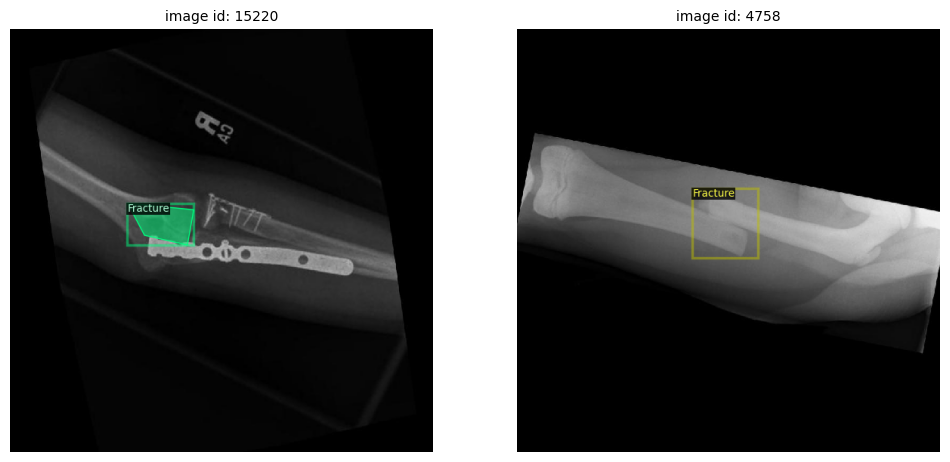

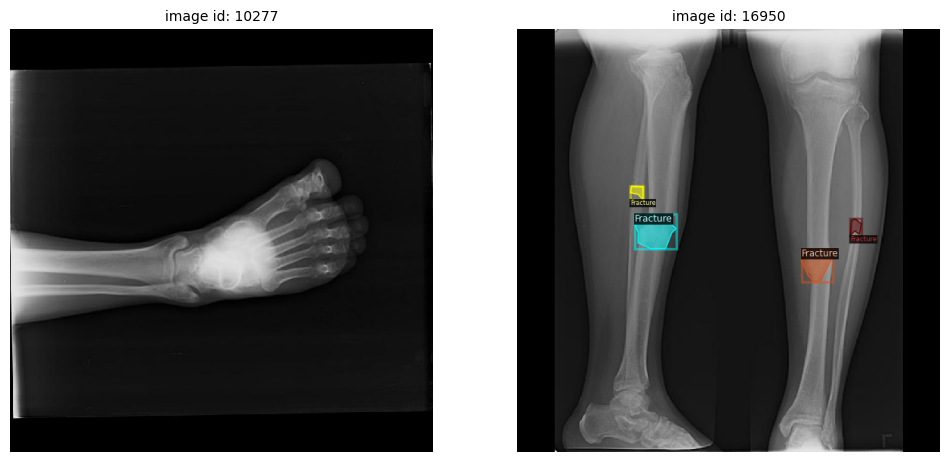

In [9]:
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 43 )
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 46 )

In [11]:
from detectron2.engine import DefaultTrainer

EPOCHS = 20000
NUM_CLASSES = 2
BASE_LR = 0.0005

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("bone_fractures_big")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0014999.pth")  
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.WEIGHT_DECAY = 0.001
cfg.SOLVER.BASE_LR = BASE_LR  
cfg.SOLVER.MAX_ITER = EPOCHS    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.SOLVER.CHECKPOINT_PERIOD = 5000

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[11/26 15:32:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:01, 239MB/s]                             


[11/26 15:32:41 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[11/26 15:33:21 d2.utils.events]:  eta: 11:07:55  iter: 19  total_loss: 1.242  loss_cls: 0.961  loss_box_reg: 0.0154  loss_rpn_cls: 0.2812  loss_rpn_loc: 0.01402    time: 1.9603  last_time: 2.0053  data_time: 0.0198  last_data_time: 0.0102   lr: 9.9905e-06  max_mem: 12954M
[11/26 15:33:58 d2.utils.events]:  eta: 11:06:52  iter: 39  total_loss: 0.9519  loss_cls: 0.673  loss_box_reg: 0.01877  loss_rpn_cls: 0.2533  loss_rpn_loc: 0.01566    time: 1.9182  last_time: 2.0050  data_time: 0.0104  last_data_time: 0.0106   lr: 1.998e-05  max_mem: 12954M
[11/26 15:34:34 d2.utils.events]:  eta: 11:05:39  iter: 59  total_loss: 0.6435  loss_cls: 0.3428  loss_box_reg: 0.01952  loss_rpn_cls: 0.2727  loss_rpn_loc: 0.01484    time: 1.8764  last_time: 1.5665  data_time: 0.0101  last_data_time: 0.0099   lr: 2.997e-05  max_mem: 12954M
[11/26 15:35:12 d2.utils.events]:  eta: 11:04:34  iter: 79  total_loss: 0.4223  loss_cls: 0.1683  loss_box_reg: 0.02008  loss_rpn_cls: 0.2191  loss_rpn_loc: 0.0119    time: 1.

In [12]:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

[11/27 02:22:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

In [13]:
def reading_metrics_from_json(metrics_path):
    metrics = []
    
    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        try:
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass

    return metric

In [14]:
train_metrics = reading_metrics_from_json('/kaggle/working/output/metrics.json')

total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
false_neg = metric(train_metrics, 'fast_rcnn/false_negative')
loss_box_reg = metric(train_metrics, 'loss_box_reg')
iters = np.arange(1,EPOCHS,EPOCHS/len(total_loss))

Text(0.5, 1.0, 'False Negative')

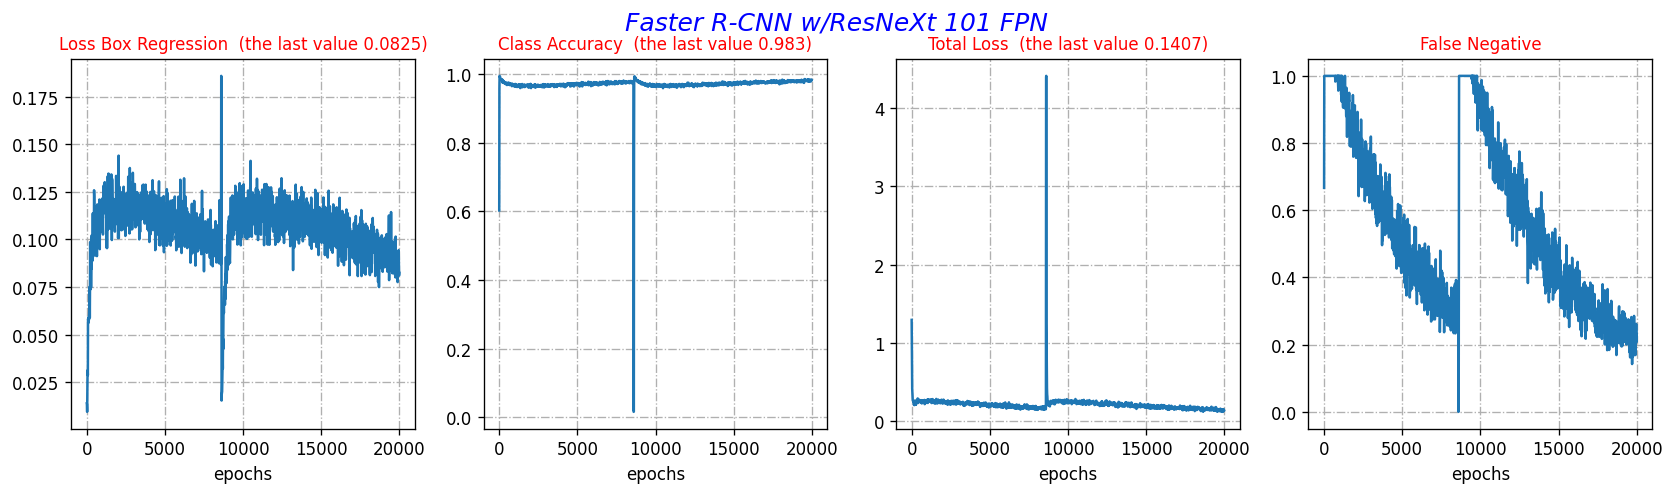

In [15]:
fig, axs = plt.subplots(1,4, figsize = (17, 4), dpi = 120)
fig.suptitle('Faster R-CNN w/ResNeXt 101 FPN', color = 'blue', fontsize=15,  style = "italic")

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, false_neg)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('False Negative', fontsize = 10, color = 'red')

In [16]:
# register_coco_instances(f"bone_fractures_val1", {},
#                             '/kaggle/input/augmented-fracture-data/valid/_annotations.coco.json',
#                             '/kaggle/input/augmented-fracture-data/valid')


my_dataset_test_metadata = MetadataCatalog.get("bone_fractures_test")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("bone_fractures_test")
# predictor = DefaultPredictor(cfg)

# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata,seed, image_scale = 0.8):
#     np.randomseed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]
    
    fig, axs = plt.subplots(3,2, figsize = (10,15), dpi = 200)
    
    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()
        
        visualizer2 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        outputs = predictor(img)
#         print(outputs)
        
#         annotations = coco_valid_big['annotations']

#         # Filter annotations for the specific image ID
#         target_annotations = [ann for ann in annotations if ann['image_id'] == img_id]

#         # Print the filtered annotations
#         print('##########################################################################')
#         print(target_annotations)
        print('##########################################################################')
        
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"), 0.3)
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
        
        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)
        
        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox)

WARNING [11/27 02:22:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/27 02:22:39 d2.data.datasets.coco]: Loaded 1723 images in COCO format from /kaggle/input/augmented-fracture-data/valid/_annotations.coco.json


##########################################################################
##########################################################################
##########################################################################
##########################################################################
##########################################################################
##########################################################################
##########################################################################
##########################################################################
##########################################################################
##########################################################################
##########################################################################
##########################################################################


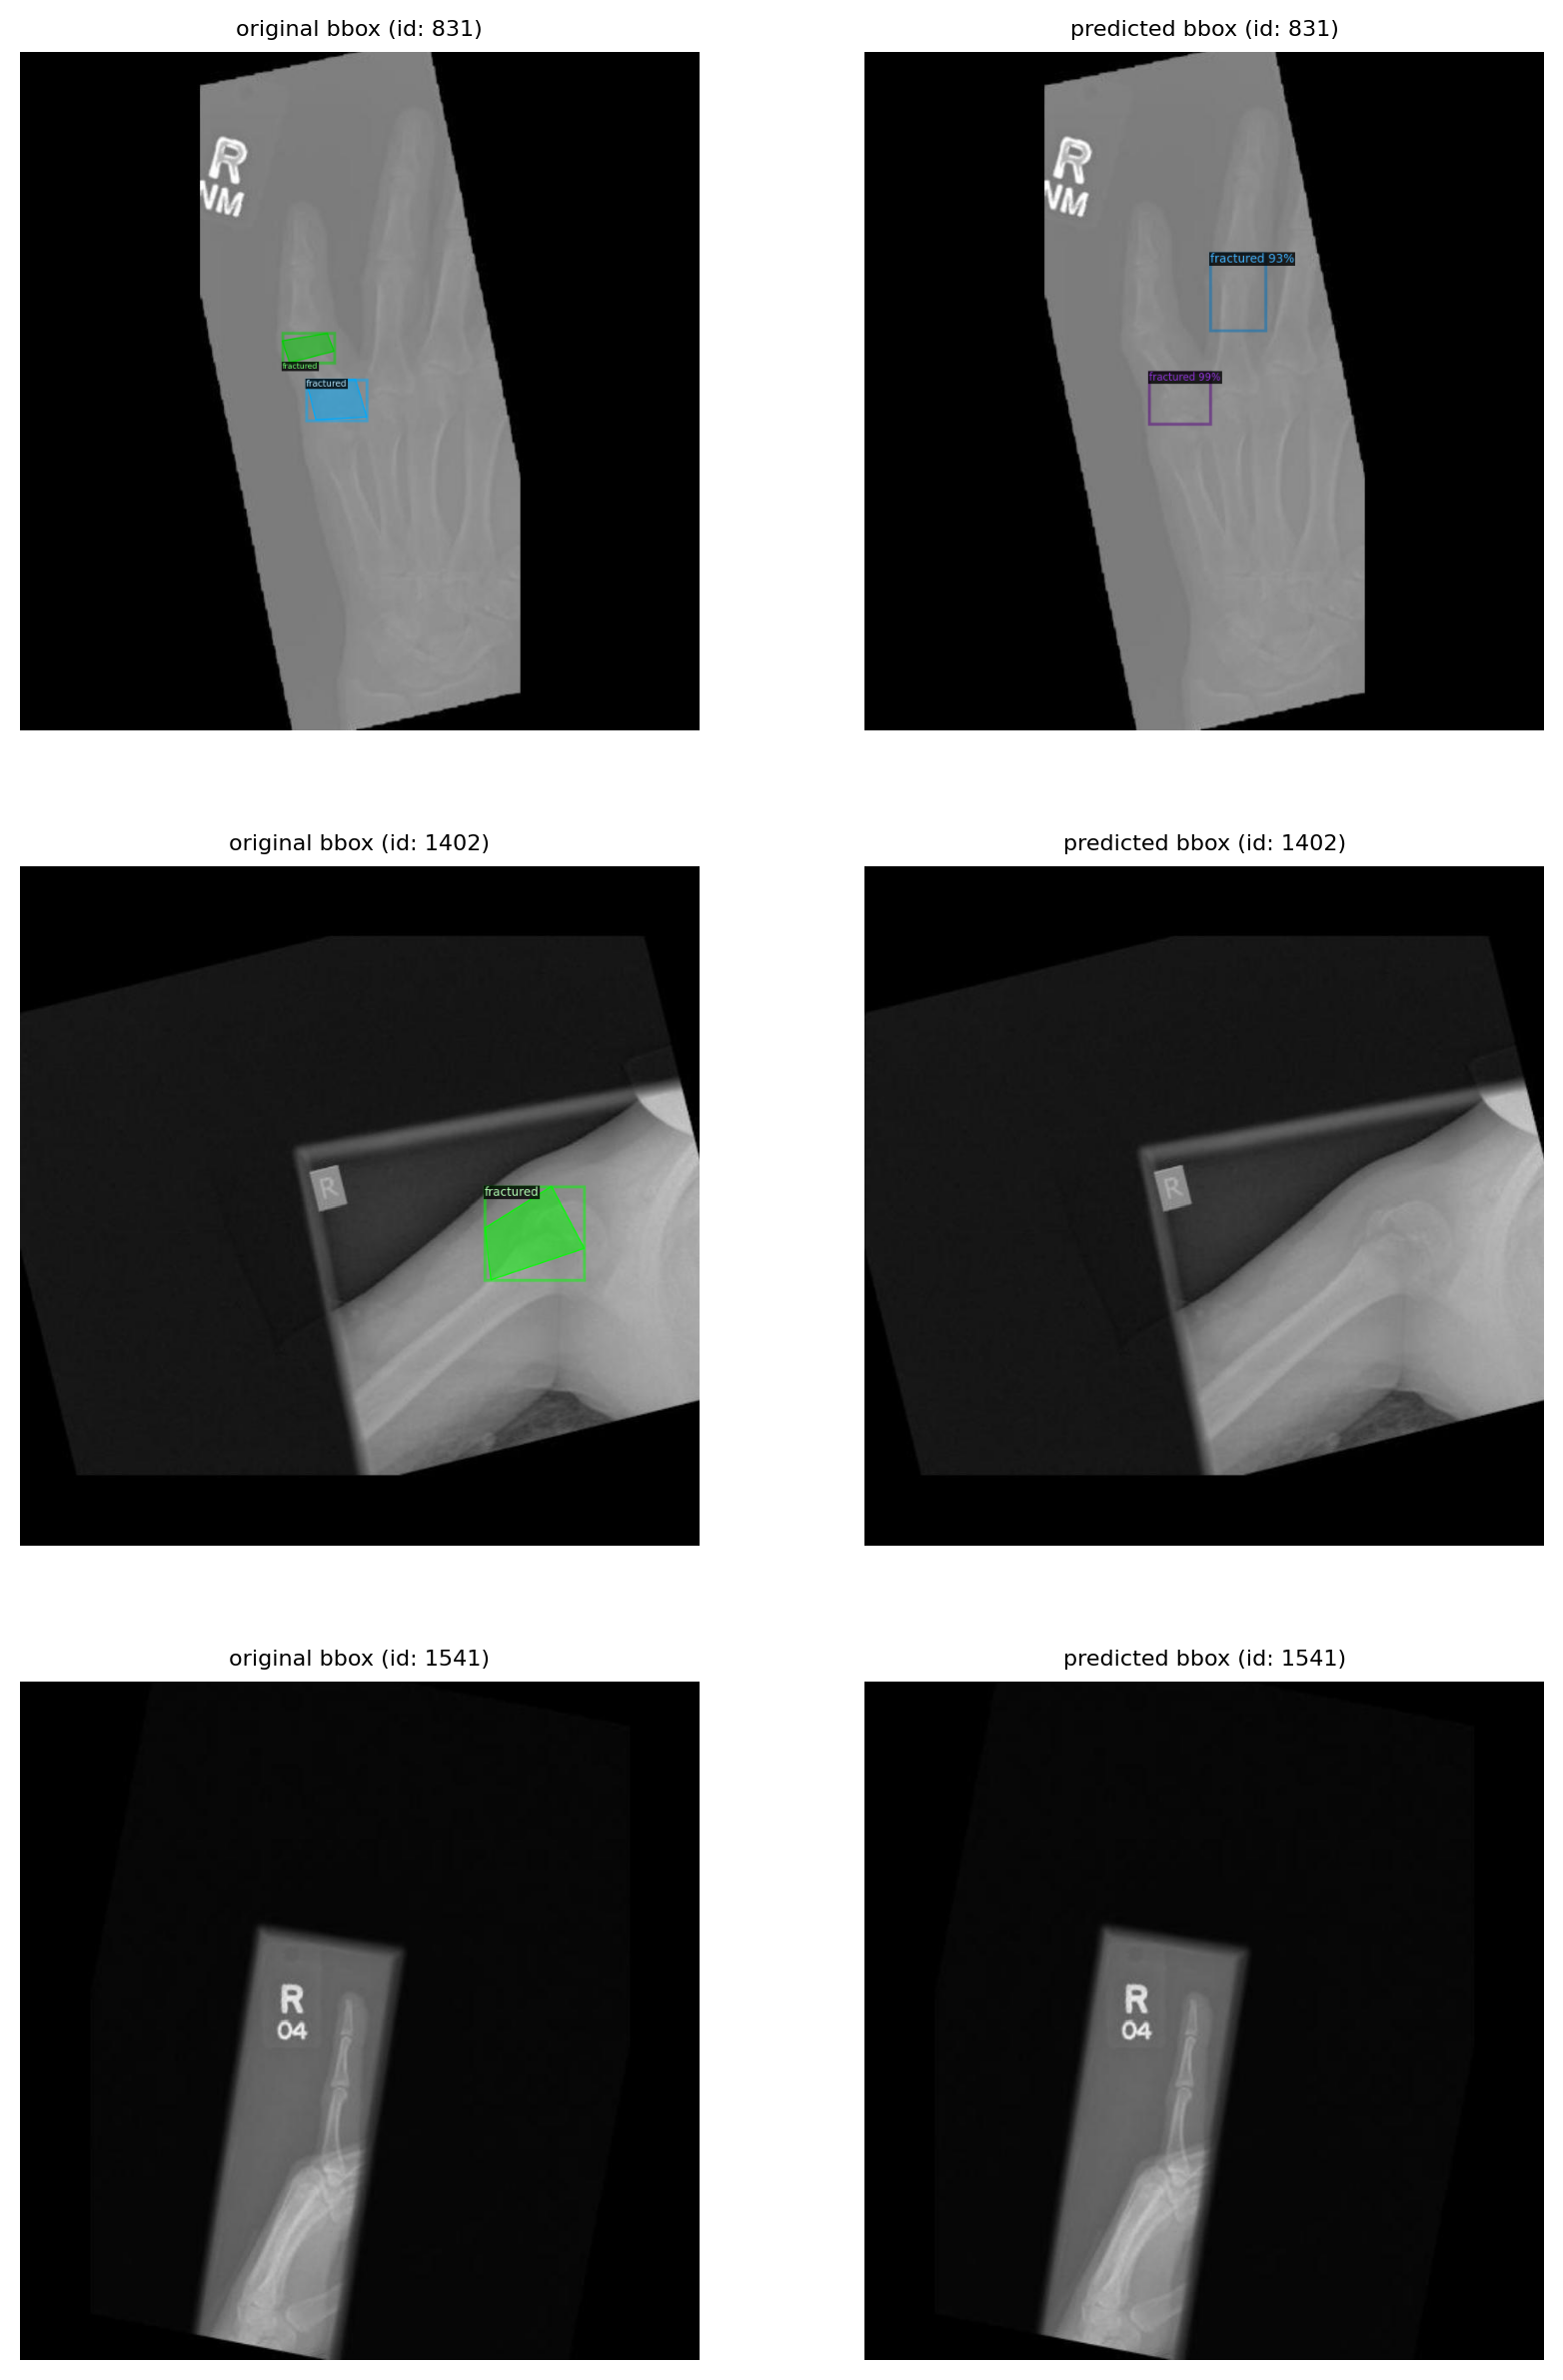

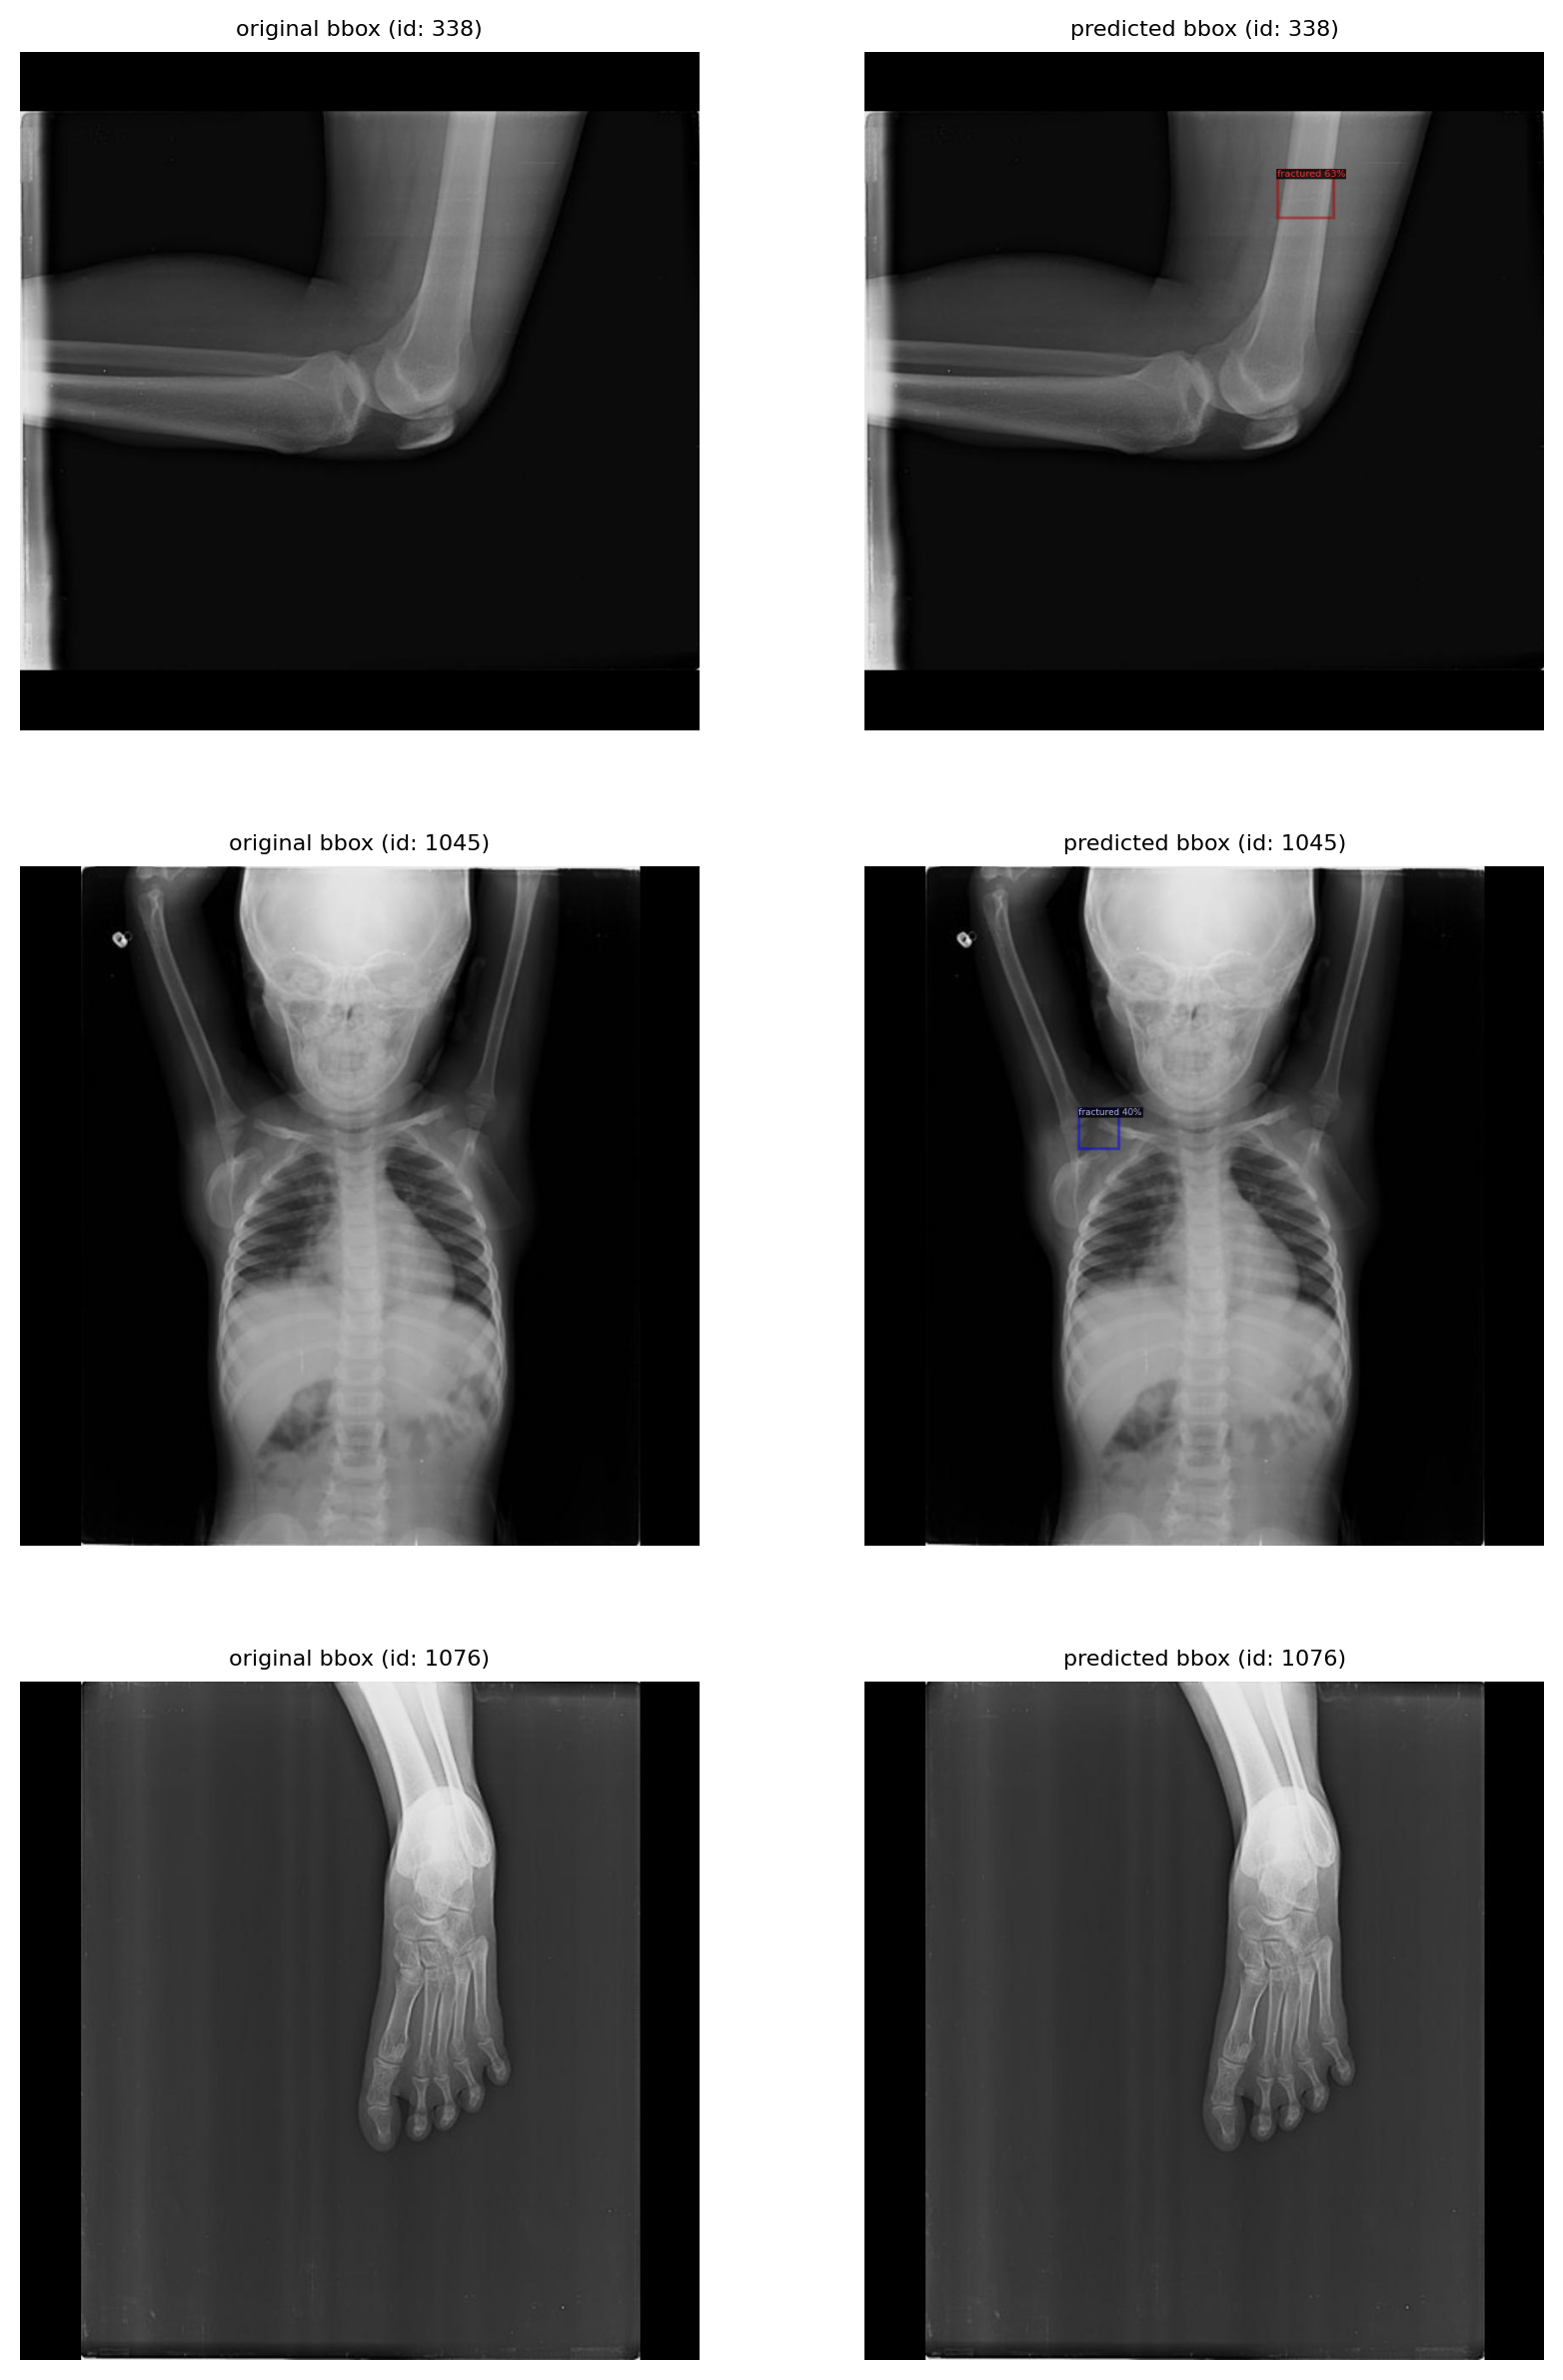

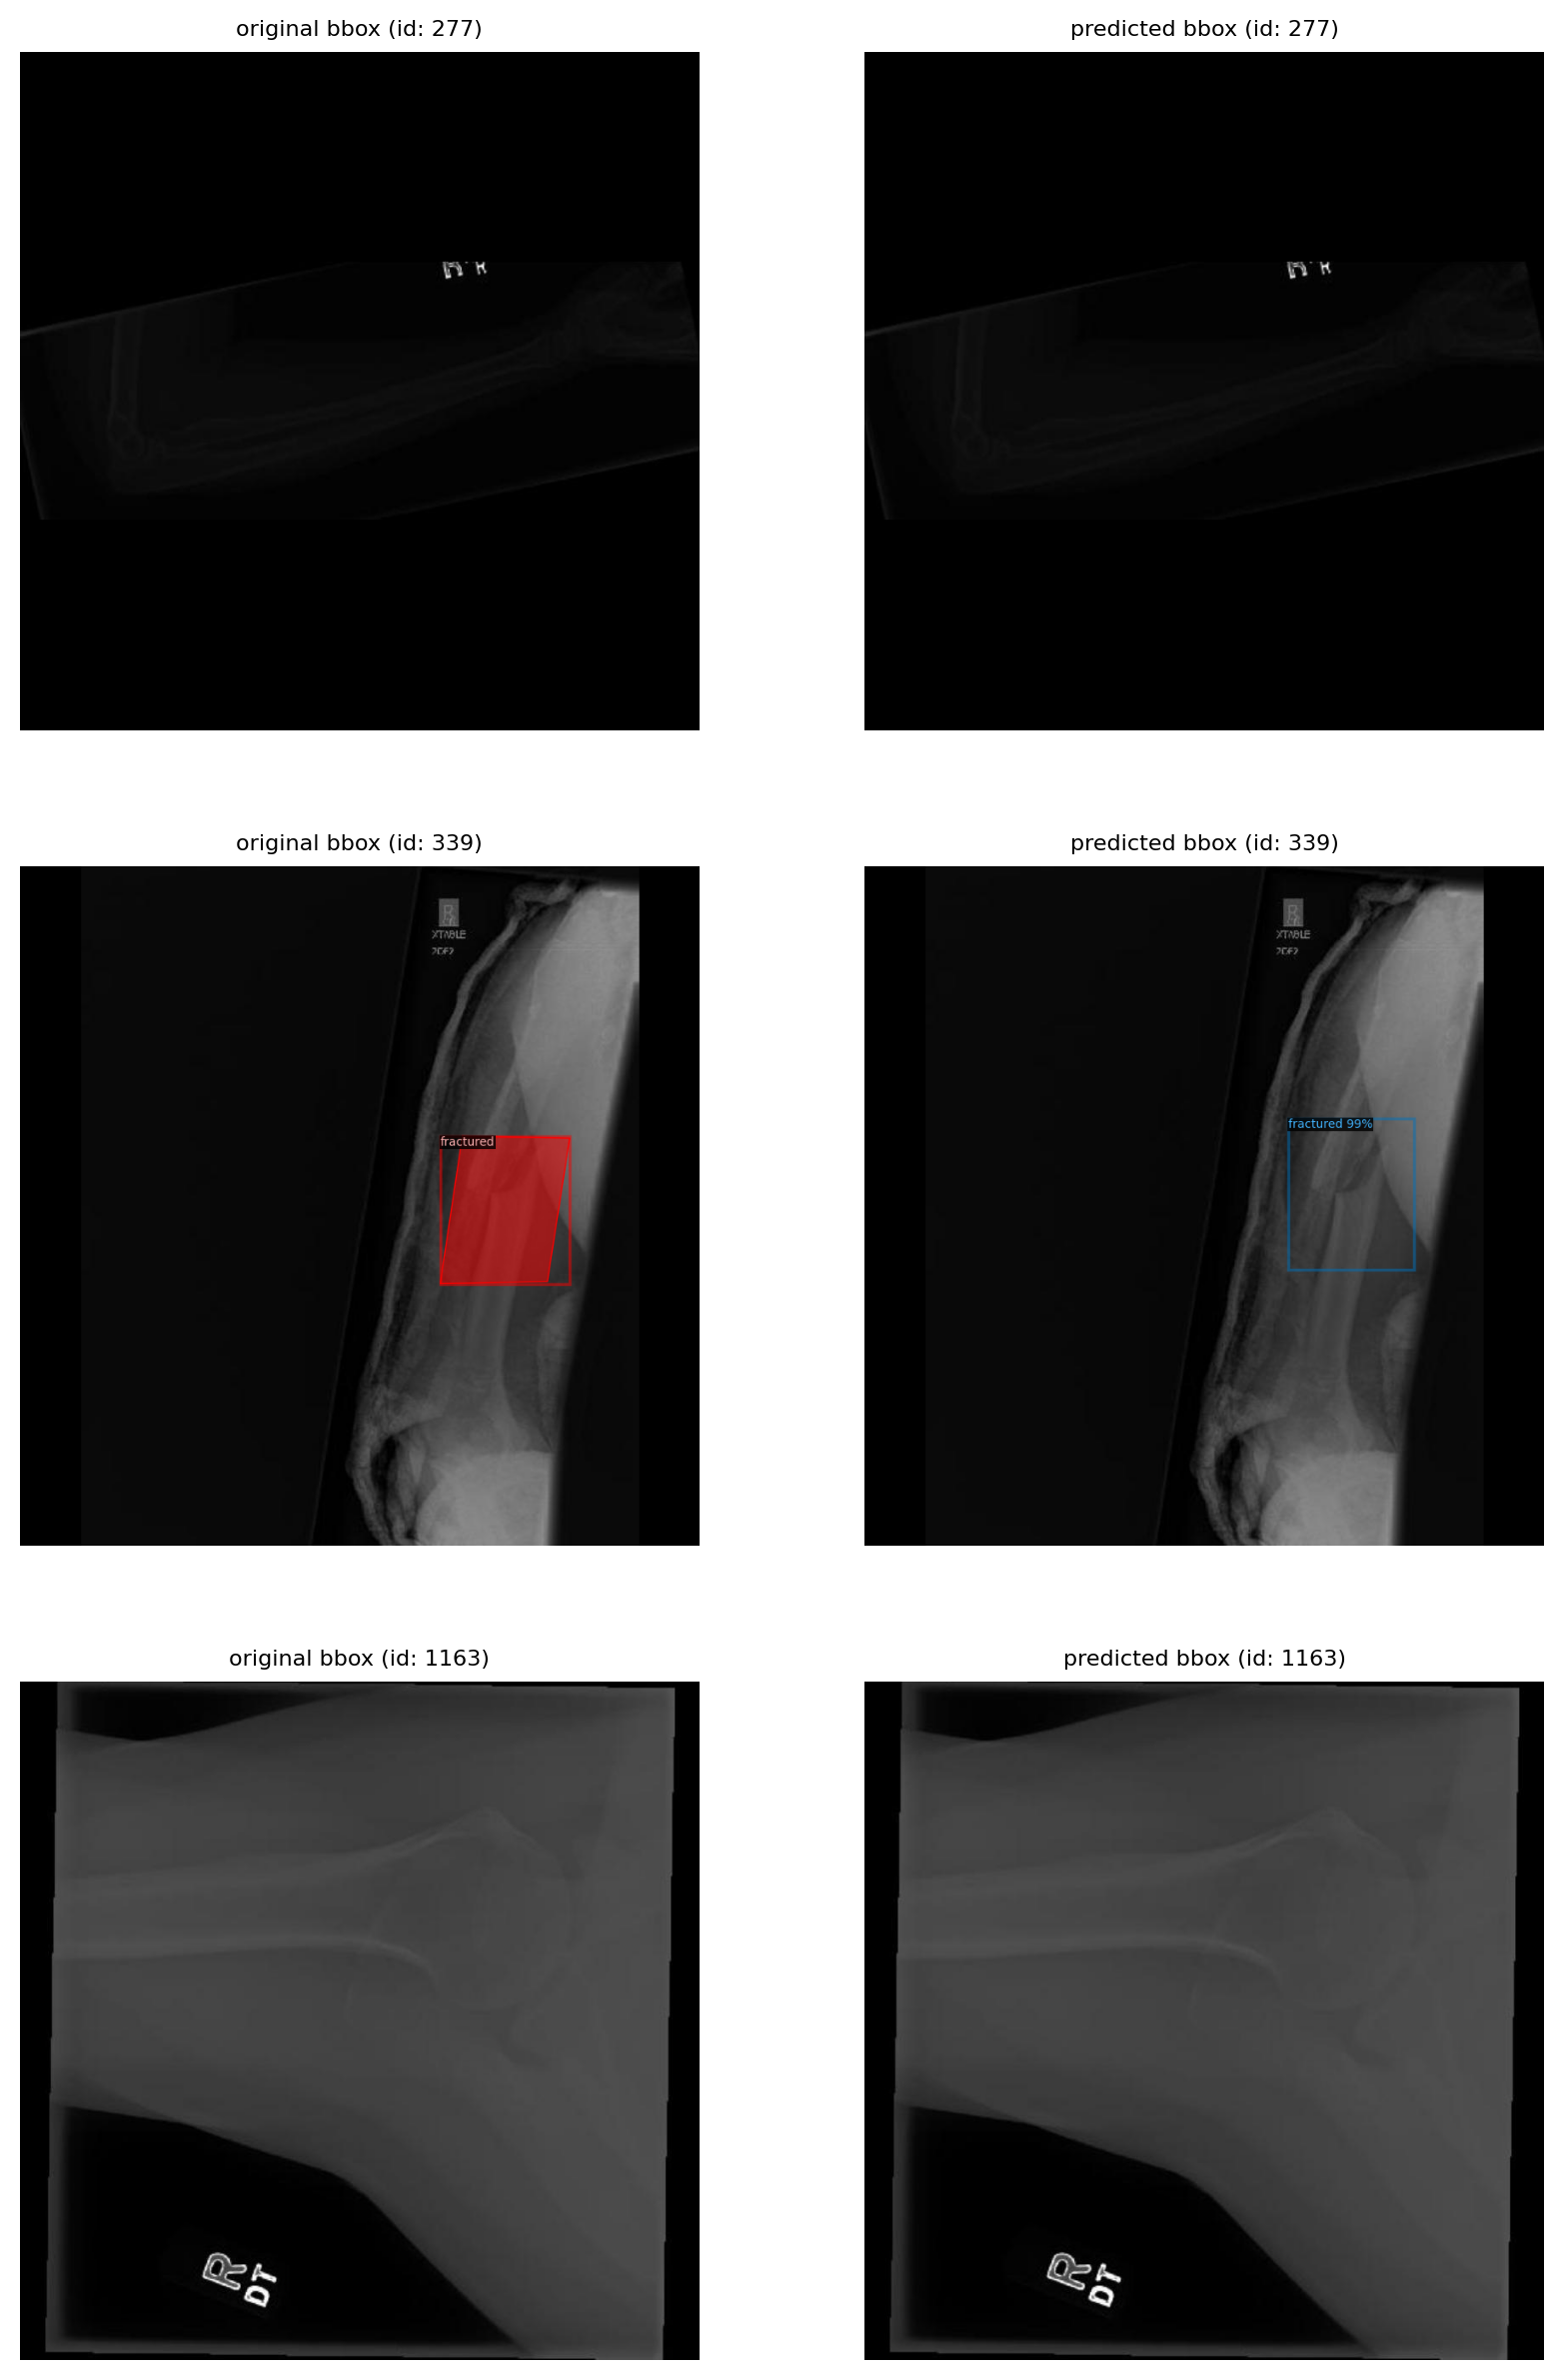

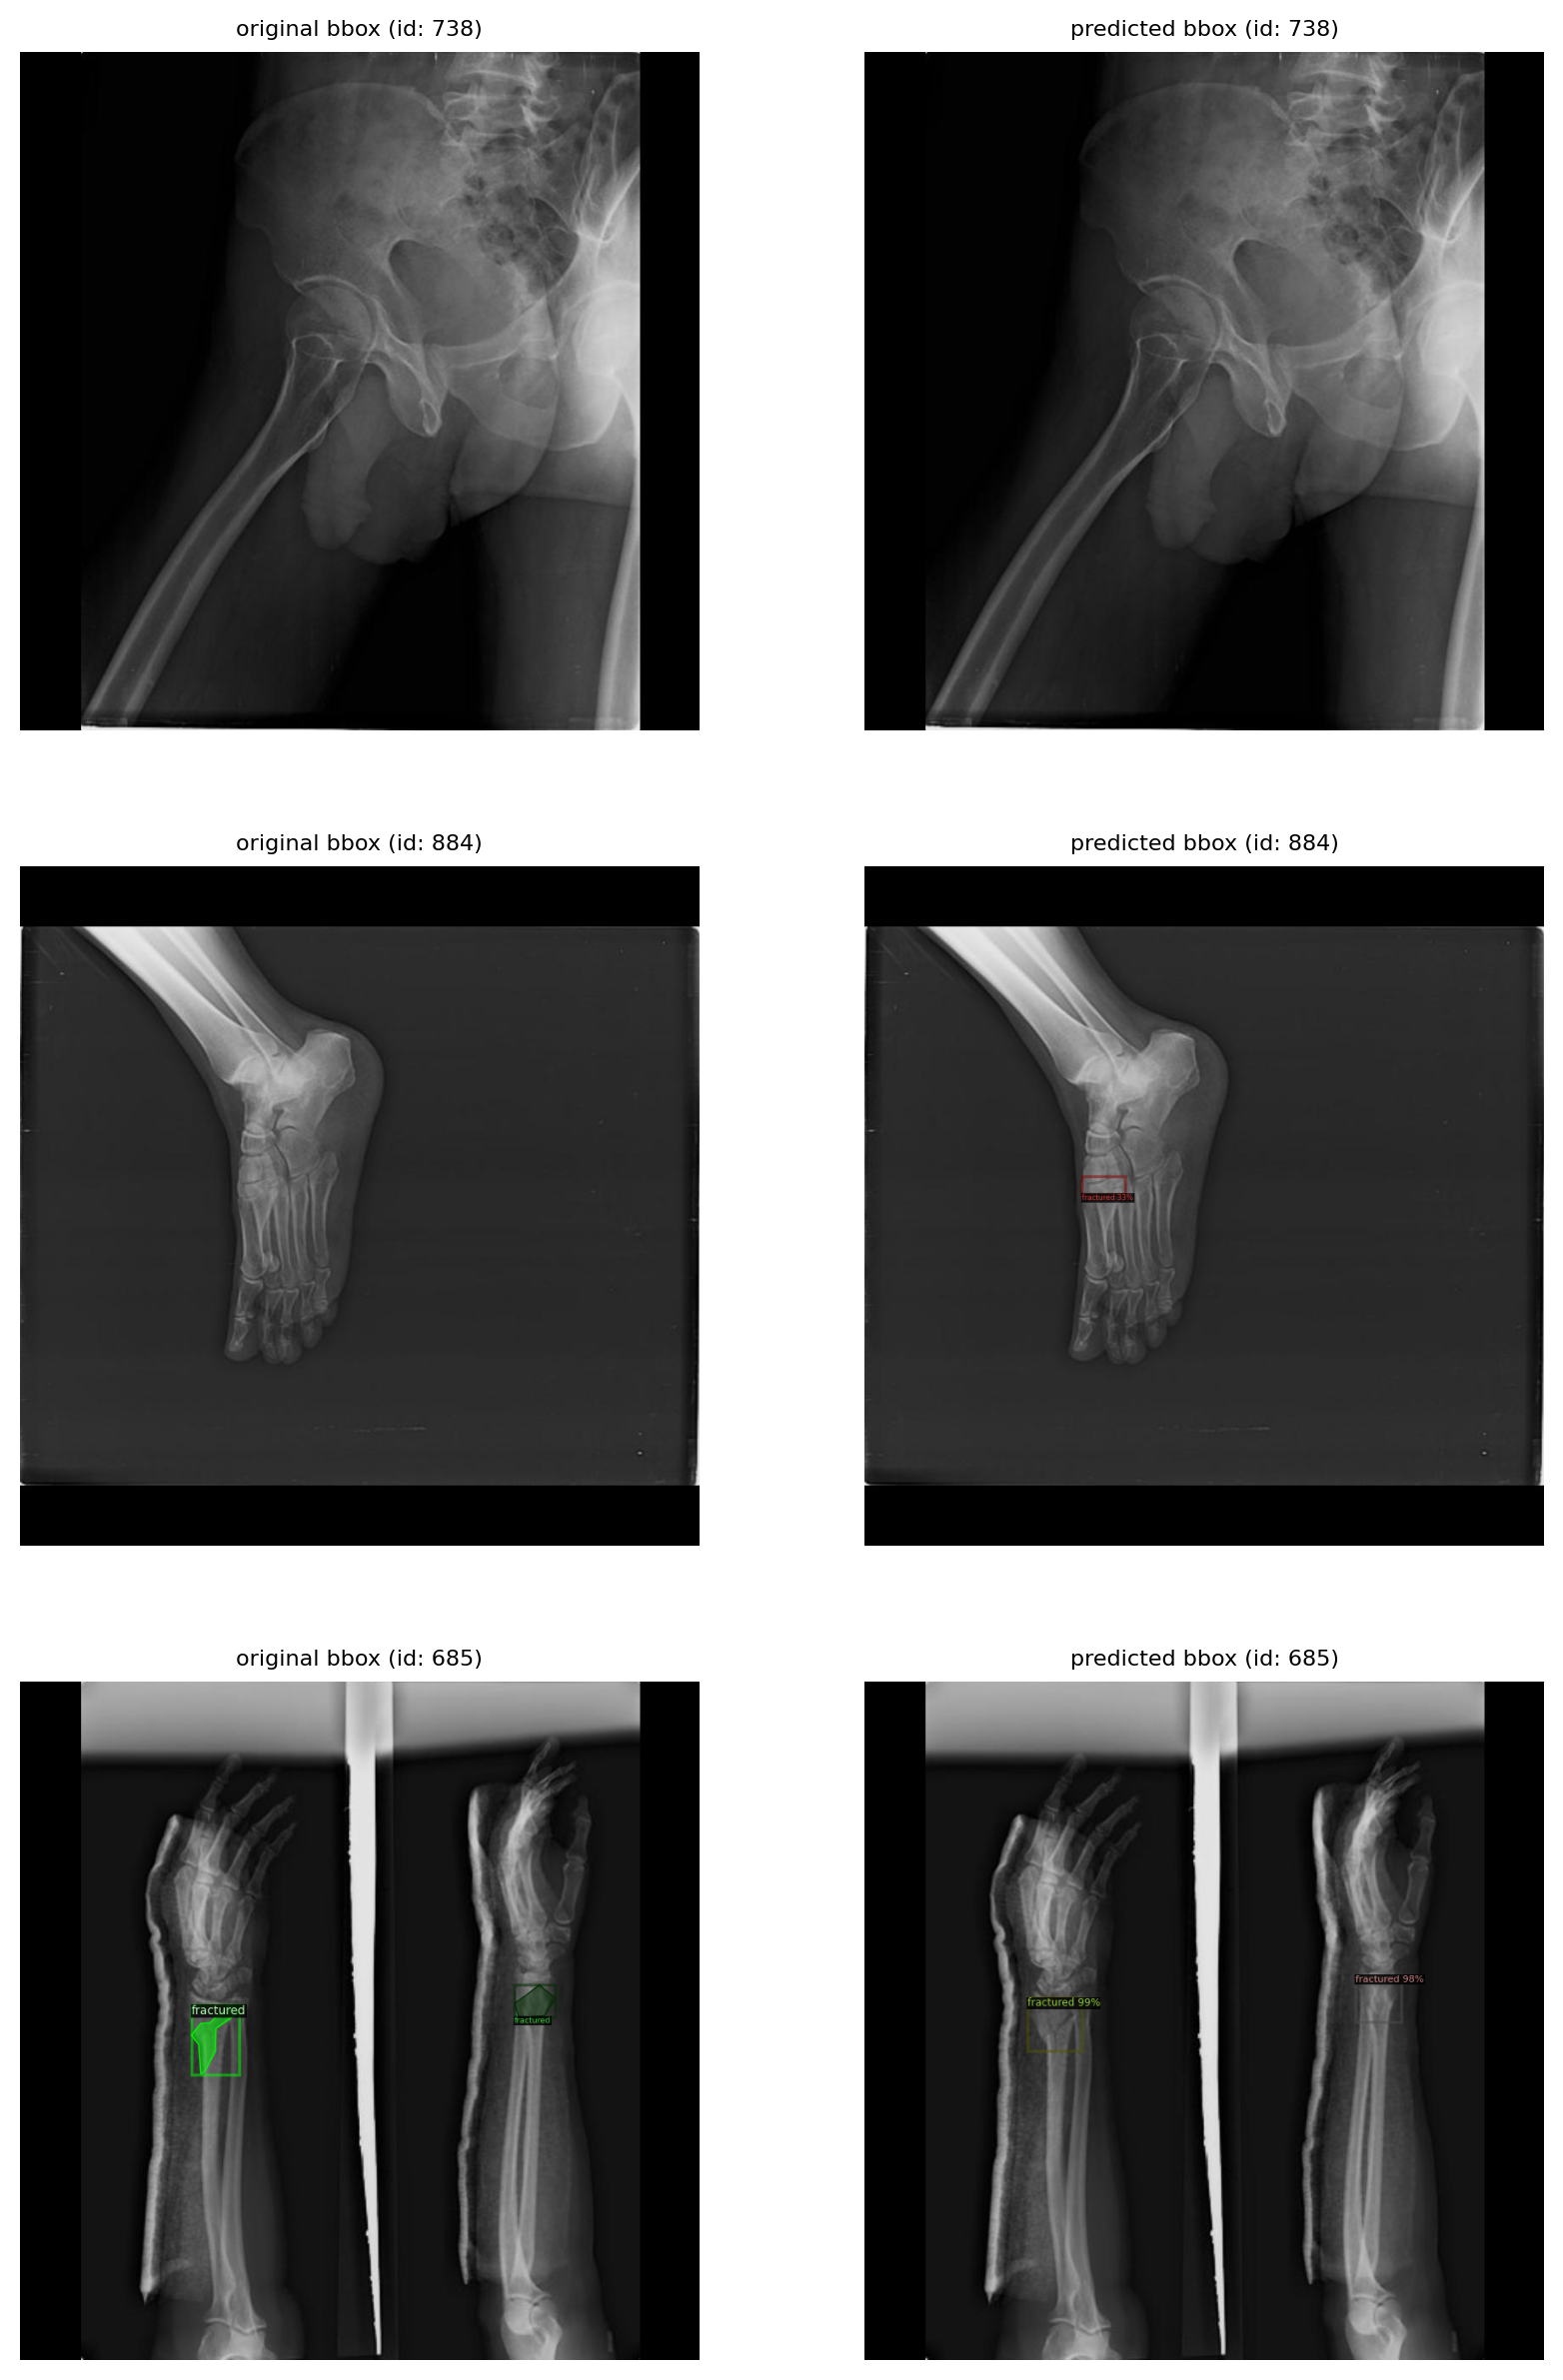

In [20]:
create_predictions(dataset_dicts,my_dataset_test_metadata, seed = 1, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata, seed = 1, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata, seed = 1, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata, seed = 1, image_scale=1)

In [18]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("bone_fractures_test", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "bone_fractures_test")
inference_on_dataset(trainer.model, test_loader, evaluator)

[11/27 02:23:06 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [11/27 02:23:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/27 02:23:06 d2.data.datasets.coco]: Loaded 1723 images in COCO format from /kaggle/input/augmented-fracture-data/valid/_annotations.coco.json
[11/27 02:23:06 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
| Fractures  | 0            | fractured  | 804          |
|            |              |            |              |
|   total    | 804          |            |              |
[11/27 02:23:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/27 02:23:06 d2.data.common]: Serializing the dat

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[11/27 02:23:07 d2.evaluation.evaluator]: Inference done 11/1723. Dataloading: 0.0013 s/iter. Inference: 0.1195 s/iter. Eval: 0.0002 s/iter. Total: 0.1211 s/iter. ETA=0:03:27
[11/27 02:23:12 d2.evaluation.evaluator]: Inference done 53/1723. Dataloading: 0.0016 s/iter. Inference: 0.1187 s/iter. Eval: 0.0002 s/iter. Total: 0.1206 s/iter. ETA=0:03:21
[11/27 02:23:17 d2.evaluation.evaluator]: Inference done 95/1723. Dataloading: 0.0016 s/iter. Inference: 0.1187 s/iter. Eval: 0.0002 s/iter. Total: 0.1206 s/iter. ETA=0:03:16
[11/27 02:23:22 d2.evaluation.evaluator]: Inference done 137/1723. Dataloading: 0.0016 s/iter. Inference: 0.1186 s/iter. Eval: 0.0002 s/iter. Total: 0.1205 s/iter. ETA=0:03:11
[11/27 02:23:27 d2.evaluation.evaluator]: Inference done 179/1723. Dataloading: 0.0016 s/iter. Inference: 0.1186 s/iter. Eval: 0.0002 s/iter. Total: 0.1204 s/iter. ETA=0:03:05
[11/27 02:23:32 d2.evaluation.evaluator]: Inference done 221/1723. Dataloading: 0.0016 s/iter. Inference: 0.1185 s/iter. Ev

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[11/27 02:26:35 d2.evaluation.evaluator]: Total inference time: 0:03:28.332136 (0.121264 s / iter per device, on 1 devices)
[11/27 02:26:35 d2.evaluation.evaluator]: Total inference pure compute time: 0:03:24 (0.119147 s / iter per device, on 1 devices)
[11/27 02:26:35 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/27 02:26:35 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[11/27 02:26:35 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.37s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.143
 Average

OrderedDict([('bbox',
              {'AP': 23.577724447204528,
               'AP50': 55.440329081033056,
               'AP75': 14.338452179879624,
               'APs': 13.363820096411786,
               'APm': 20.209822701301235,
               'APl': 34.26478473492547,
               'AP-Fractures': nan,
               'AP-fractured': 23.577724447204528})])

In [1]:
with open('/kaggle/input/augmented-fracture-data/valid/_annotations.coco.json', 'r') as f:
    coco_valid_big = json.load(f)
    
coco_valid_big['annotations']

NameError: name 'json' is not defined